# Python implementation of Time Series Forecast using Prophet

Because of low-memory, we only managed to calculate everything using one thread. These three exports allow us to restrict the algorithms of Numpy and other libraries to one thread.

In [6]:
!export MKL_NUM_THREADS=1
!export NUMEXPR_NUM_THREADS=1
!export OMP_NUM_THREADS=1

Prophet is a Facebook library. 

In [8]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline

The dataset used is the Avocado dataset, which is composed of 18249 rows and 13 columns.

The aim of the implementation is to predict the price of avocados over time, based on several features.

In [3]:
df = pd.read_csv('avocado.csv', index_col=0)

In [46]:
df

Date  AveragePrice  Total Volume     4046       4225    4770  \
0   2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1   2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2   2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3   2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4   2015-11-29          1.28      51039.60   941.48   43838.39   75.78   
..         ...           ...           ...      ...        ...     ...   
7   2018-02-04          1.63      17074.83  2046.96    1529.20    0.00   
8   2018-01-28          1.71      13888.04  1191.70    3431.50    0.00   
9   2018-01-21          1.87      13766.76  1191.92    2452.79  727.94   
10  2018-01-14          1.93      16205.22  1527.63    2981.04  727.01   
11  2018-01-07          1.62      17489.58  2894.77    2356.13  224.53   

    Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0      8696.87     8603.62       93.25          0.0  conventional  2015   
1      9505.56     9408.07       97.49          0.0  conventional  2015   
2      8145.35     8042.21      103.14          0.0  conventional  2015   
3      5811.16     5677.40      133.76          0.0  conventional  2015   
4      6183.95     5986.26      197.69          0.0  conventional  2015   
..         ...         ...         ...          ...           ...   ...   
7     13498.67    13066.82      431.85          0.0       organic  2018   
8      9264.84     8940.04      324.80          0.0       organic  2018   
9      9394.11     9351.80       42.31          0.0       organic  2018   
10    10969.54    10919.54       50.00          0.0       organic  2018   
11    12014.15    11988.14       26.01          0.0       organic  2018   

              region  
0             Albany  
1             Albany  
2             Albany  
3             Albany  
4             Albany  
..               ...  
7   WestTexNewMexico  
8   WestTexNewMexico  
9   WestTexNewMexico  
10  WestTexNewMexico  
11  WestTexNewMexico  

[18249 rows x 13 columns]

In [5]:
df.describe()

AveragePrice  Total Volume          4046          4225          4770  \
count  18249.000000  1.824900e+04  1.824900e+04  1.824900e+04  1.824900e+04   
mean       1.405978  8.506440e+05  2.930084e+05  2.951546e+05  2.283974e+04   
std        0.402677  3.453545e+06  1.264989e+06  1.204120e+06  1.074641e+05   
min        0.440000  8.456000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%        1.100000  1.083858e+04  8.540700e+02  3.008780e+03  0.000000e+00   
50%        1.370000  1.073768e+05  8.645300e+03  2.906102e+04  1.849900e+02   
75%        1.660000  4.329623e+05  1.110202e+05  1.502069e+05  6.243420e+03   
max        3.250000  6.250565e+07  2.274362e+07  2.047057e+07  2.546439e+06   

         Total Bags    Small Bags    Large Bags    XLarge Bags          year  
count  1.824900e+04  1.824900e+04  1.824900e+04   18249.000000  18249.000000  
mean   2.396392e+05  1.821947e+05  5.433809e+04    3106.426507   2016.147899  
std    9.862424e+05  7.461785e+05  2.439660e+05   17692.894652      0.939938  
min    0.000000e+00  0.000000e+00  0.000000e+00       0.000000   2015.000000  
25%    5.088640e+03  2.849420e+03  1.274700e+02       0.000000   2015.000000  
50%    3.974383e+04  2.636282e+04  2.647710e+03       0.000000   2016.000000  
75%    1.107834e+05  8.333767e+04  2.202925e+04     132.500000   2017.000000  
max    1.937313e+07  1.338459e+07  5.719097e+06  551693.650000   2018.000000

In [9]:
from sklearn.preprocessing import LabelEncoder

We want to convert all values of features into numeric values. 

We use Label Encoder to do that.

In [11]:
le = LabelEncoder()
df.iloc[:,10] = le.fit_transform(df.iloc[:,10])
df.shape

(18249, 13)

We split the price (Y) from the other features (X) so that we can train our model. 

In [12]:
X = df[['Date', 'Total Volume', '4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type']]
y = df.iloc[:,1]

We convert the string-formatted dates into Numpy Date format to allow Prophet understanding the date. 

In [13]:
train = pd.DataFrame()
train['ds'] = pd.to_datetime(X['Date'])
train['y'] = y
train.shape

(18249, 2)

Our train dataset is composed of average prices and corresponding dates.

In [15]:
train

ds     y
0  2015-12-27  1.33
1  2015-12-20  1.35
2  2015-12-13  0.93
3  2015-12-06  1.08
4  2015-11-29  1.28
..        ...   ...
7  2018-02-04  1.63
8  2018-01-28  1.71
9  2018-01-21  1.87
10 2018-01-14  1.93
11 2018-01-07  1.62

[18249 rows x 2 columns]

We create the Prophet model with the basic parameters and we fit it with the training data.

In [72]:
prophet_basic = Prophet()
prophet_basic.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


We complete the dates column with the next 300 days.

The whole history is not displayed in future because make_future_dataframe method removes multiple occurrences of the same date.

In [80]:
future = prophet_basic.make_future_dataframe(periods=300)
future

ds
0   2015-01-04
1   2015-01-11
2   2015-01-18
3   2015-01-25
4   2015-02-01
..         ...
464 2019-01-15
465 2019-01-16
466 2019-01-17
467 2019-01-18
468 2019-01-19

[469 rows x 1 columns]

We predict the future average prices over the dates created in the ``future`` dataframe using the basic Prophet model.

In [81]:
forecast = prophet_basic.predict(future)

We plot the forecast.  
The black dots correspond to the real prices for each past date.  
The light blue area represents the prediction for the future prices.   
A trend line is displayed in blue.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



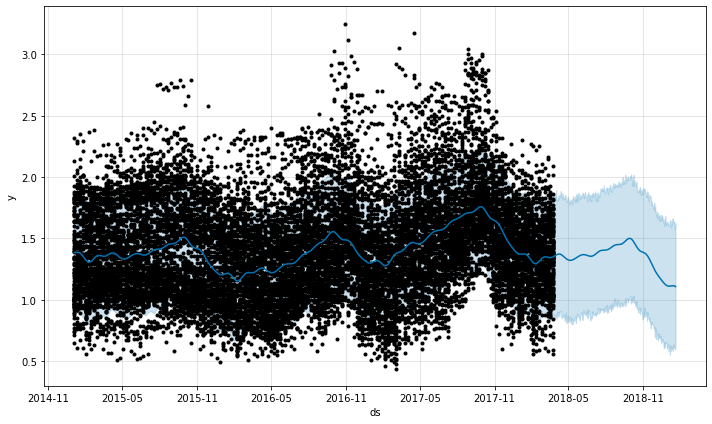

In [82]:
fig1 = prophet_basic.plot(forecast)

We plot the components of the prediction which are the trend and seasonality. 

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



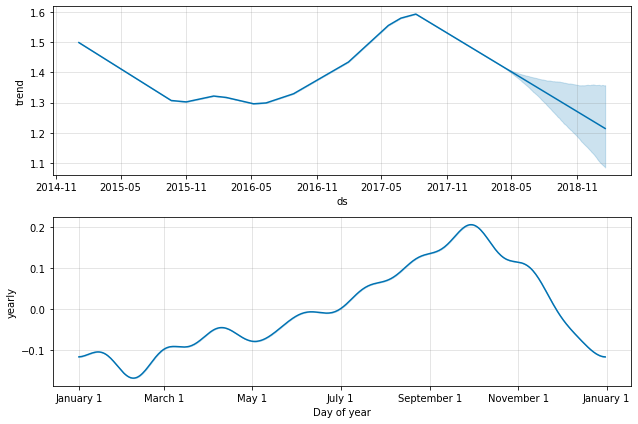

In [83]:
fig1 = prophet_basic.plot_components(forecast)

In [84]:
from fbprophet.plot import add_changepoints_to_plot

We display some changepoints on the results graph from the previous prediction. By default, there are 25 changepoints.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



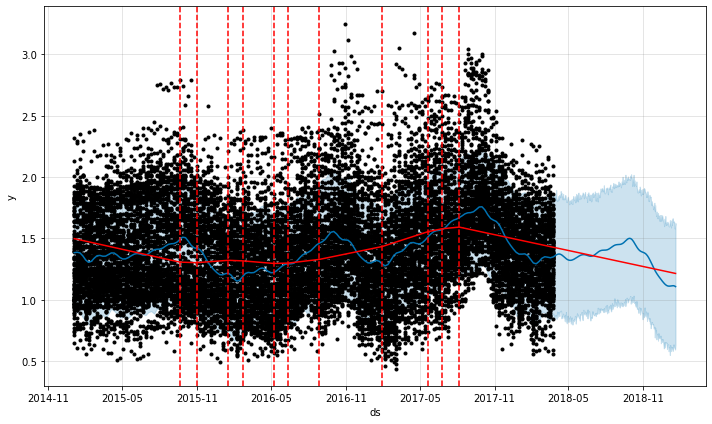

In [85]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

We print the changepoints to check them. 

In [86]:
prophet_basic.changepoints

584     2015-02-08
1168    2015-03-15
1752    2015-04-26
2336    2015-05-31
2920    2015-07-12
3504    2015-08-16
4087    2015-09-20
4671    2015-11-01
5255    2015-12-06
5839    2016-01-17
6423    2016-02-21
7007    2016-03-27
7591    2016-05-08
8175    2016-06-12
8759    2016-07-24
9343    2016-08-28
9927    2016-10-02
10511   2016-11-13
11094   2016-12-18
11678   2017-01-29
12262   2017-03-05
12846   2017-04-09
13430   2017-05-21
14014   2017-06-25
14598   2017-08-06
Name: ds, dtype: datetime64[ns]

We create a Prophet model using changepoints at a range of 0.9 (= using 90% of the history).  
We fit this new model on the training data, predict the future prices, and we plot the forecast.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



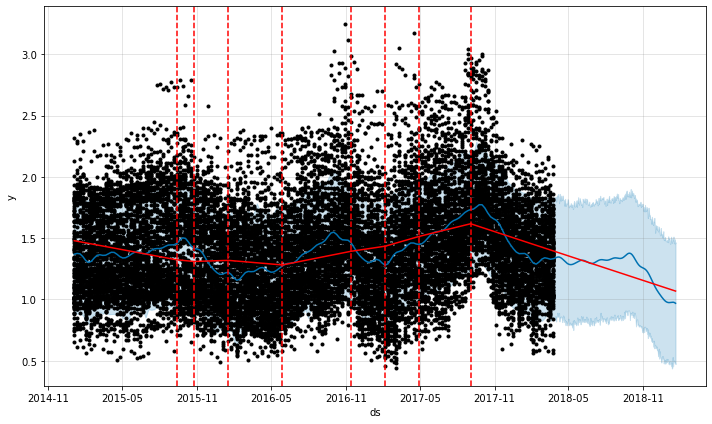

In [93]:
pro_change = Prophet(changepoint_range=0.9)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

We create a Prophet model using 20 changepoints and a yearly seasonality (to take into account seasonal events such as holidays).    
We fit this new model on the training data, predict the future prices, and we plot the forecast.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



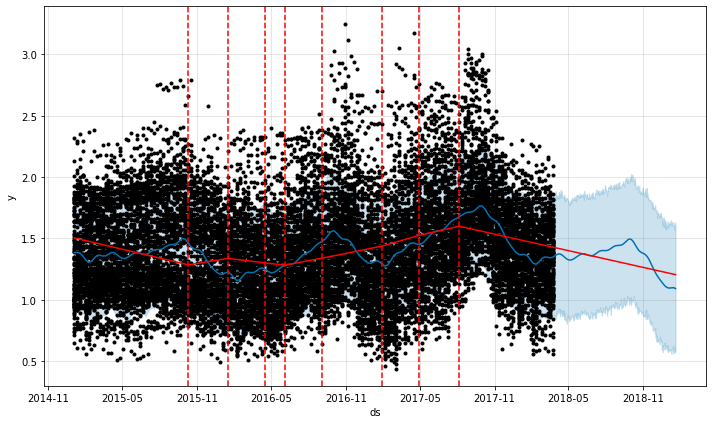

In [94]:
pro_change = Prophet(n_changepoints=20, yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

We create a Prophet model using 20 changepoints and a yearly seasonality (to take into account seasonal events such as holidays). We set the changepoints prior scale to 0.08 so that the trend will be more flexible (the default is 0.05).        
We fit this new model on the training data, predict the future prices, and we plot the forecast.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



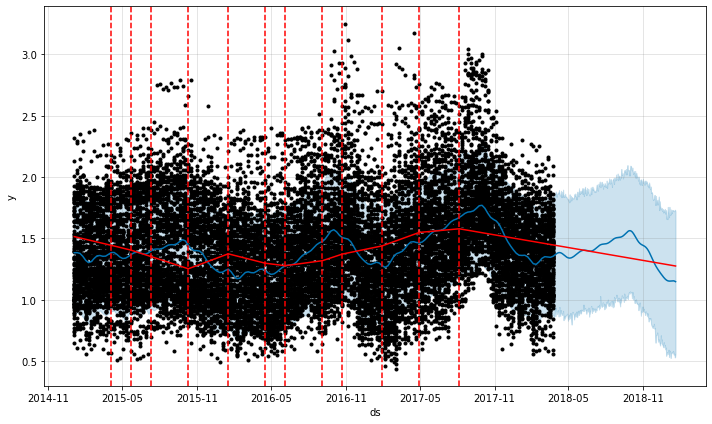

In [95]:
pro_change = Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

We create a Prophet model using 20 changepoints and a yearly seasonality (to take into account seasonal events such as holidays). We set the changepoints prior scale to 0.001 so that the trend will be less flexible (the default is 0.05).        
We fit this new model on the training data, predict the future prices, and we plot the forecast.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



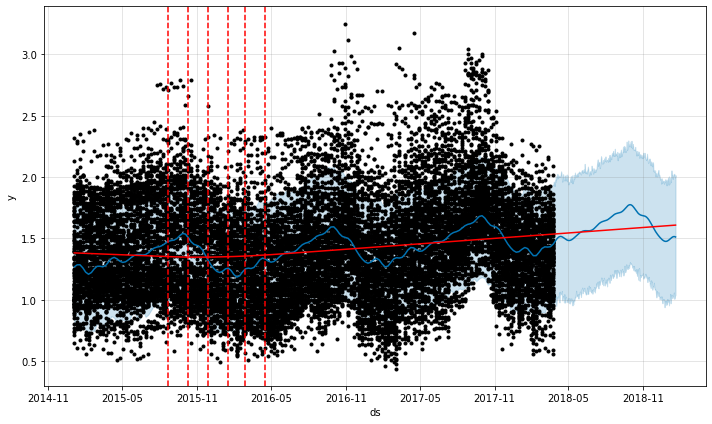

In [97]:
pro_change = Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.001)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

We create a dataframe containing two dates impacting the price of avocados, because these dates correspond to the National Avocado Day and the Guacamole Day (in the US). The prices on the day before will be also impacted by the holiday so we use the parameter lower window to consider this.

In [98]:
avocado_season = pd.DataFrame({
  'holiday': 'avocado season',
  'ds': pd.to_datetime(['2014-07-31', '2014-09-16', 
                        '2015-07-31', '2015-09-16',
                        '2016-07-31', '2016-09-16',
                        '2017-07-31', '2017-09-16',
                       '2018-07-31', '2018-09-16',
                        '2019-07-31', '2019-09-16']),
  'lower_window': -1,
  'upper_window': 0,
})

We create a Prophet model precising these impacting dates.    
We fit this new model on the training data, predict the future monthly prices, and we plot the forecast.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



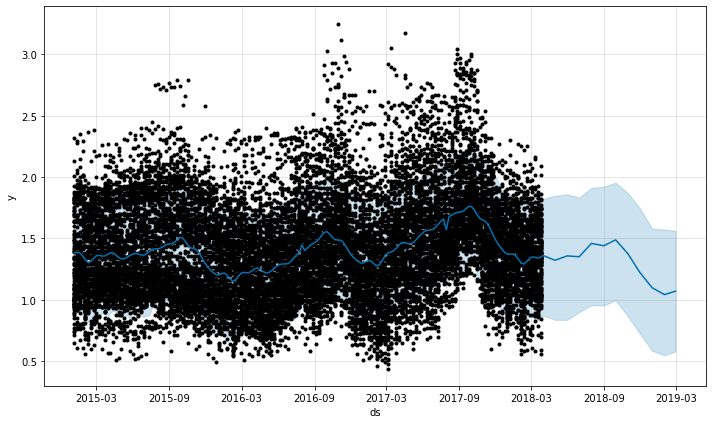

In [102]:
pro_holiday= Prophet(holidays=avocado_season)
pro_holiday.fit(train)
future_data = pro_holiday.make_future_dataframe(periods=12, freq = 'm')
 
#forecast the data for future data
forecast_data = pro_holiday.predict(future_data)
fig = pro_holiday.plot(forecast_data)

We split the data between train and test to fit a new model and evaluate it.

In [103]:
train['type'] = X['type']
train['Total Volume'] = X['Total Volume']
train['4046'] = X['4046']
train['4225'] = X['4225']
train['4770'] = X['4770']
train['Small Bags'] = X['Small Bags']

train_X = train[:18000]
test_X = train[18000:]

We create a new Prophet model with additional regressors to include information about other feature such as the type, volume, PLU, and size of bags.    
We fit this new model on the training part of the dataset and make predictions over 249 days using the test data.   
We plot these predictions in blue.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



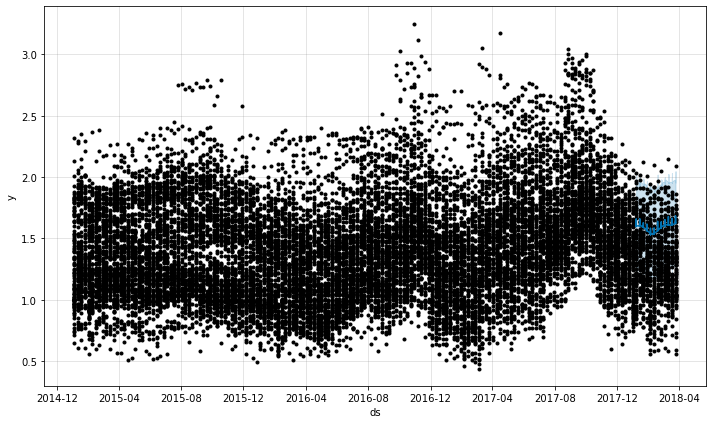

In [104]:
#Additional Regressor
pro_regressor= Prophet()
pro_regressor.add_regressor('type')
pro_regressor.add_regressor('Total Volume')
pro_regressor.add_regressor('4046')
pro_regressor.add_regressor('4225')
pro_regressor.add_regressor('4770')
pro_regressor.add_regressor('Small Bags')

#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=249)

#forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);